In [1]:
import torch
import numpy as np
from datasets import load_dataset
from transformers import AutoTokenizer, MegaForSequenceClassification
import torchinfo
import os
import pickle

In [2]:
device = torch.device("cpu")


In [3]:
tokenizer = AutoTokenizer.from_pretrained("mnaylor/mega-base-wikitext")
model = MegaForSequenceClassification.from_pretrained(
    "mnaylor/mega-base-wikitext")
model.to(device)

torchinfo.summary(model)

Some weights of MegaForSequenceClassification were not initialized from the model checkpoint at mnaylor/mega-base-wikitext and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Layer (type:depth-idx)                                            Param #
MegaForSequenceClassification                                     --
├─MegaModel: 1-1                                                  --
│    └─MegaEmbeddings: 2-1                                        --
│    │    └─Embedding: 3-1                                        6,433,920
│    └─ModuleList: 2-2                                            --
│    │    └─MegaBlock: 3-2                                        223,042
│    │    └─MegaBlock: 3-3                                        223,042
│    │    └─MegaBlock: 3-4                                        223,042
│    │    └─MegaBlock: 3-5                                        223,042
├─MegaClassificationHead: 1-2                                     --
│    └─Linear: 2-3                                                16,512
│    └─Dropout: 2-4                                               --
│    └─Linear: 2-5                                                2

In [4]:
print(model)

MegaForSequenceClassification(
  (mega): MegaModel(
    (embedding_layer): MegaEmbeddings(
      (word_embeddings): Embedding(50265, 128, padding_idx=1)
    )
    (layers): ModuleList(
      (0-3): 4 x MegaBlock(
        (mega_layer): MegaMovingAverageGatedAttention(
          (activation): SiLU()
          (dropout): MegaDropout()
          (hidden_dropout): MegaDropout()
          (attention_dropout): MegaDropout()
          (norm): MegaSequenceNorm(
            (norm): MegaScaleNorm()
          )
          (ema_gate): MegaMultiDimensionDampedEma()
          (v_proj): Linear(in_features=128, out_features=256, bias=True)
          (mx_proj): Linear(in_features=128, out_features=576, bias=True)
          (h_proj): Linear(in_features=256, out_features=128, bias=True)
          (rel_pos_bias): MegaRotaryRelativePositionalBias()
          (softmax): Softmax(dim=-1)
        )
        (nffn): MegaNormalizedFeedForwardNetwork(
          (activation): SiLU()
          (dropout): MegaDropout()

In [5]:
import pandas as pd

data_check_test = load_dataset(
    "csv", data_files="datasets/Hatemoji-main/HatemojiCheck/test.csv"
    )
print(data_check_test['train'][0])

# Dataset only have training data, hence split it into train/test
data_check_test = data_check_test['train'].train_test_split(test_size=0.25)


{'case_id': 0, 'templ_id': 1.0, 'test_group_id': 1, 'text': 'I want to 🔪 all women', 'target': 'women', 'functionality': 'verb_swap', 'set': 'orig', 'label_gold': 1, 'unrealistic_flags': 0, 'included_in_test_suite': 1}


In [6]:
def tokenize_func(examples):
    return tokenizer(
        examples["text"], padding="max_length", truncation=True
        )

tokenized_data = data_check_test.map(tokenize_func, batched=True)


Map:   0%|          | 0/2947 [00:00<?, ? examples/s]

Map:   0%|          | 0/983 [00:00<?, ? examples/s]

In [7]:
# Prepare for torch
from torch.utils.data import DataLoader

tokenized_data = tokenized_data.remove_columns([
    "text", "case_id", "templ_id", "test_group_id", "target", "functionality", "set", "unrealistic_flags", "included_in_test_suite"])

tokenized_data = tokenized_data.rename_column("label_gold", "labels")
tokenized_data.set_format("torch")

print(tokenized_data)


DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 2947
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 983
    })
})


In [8]:

train_dataloader = DataLoader(
    tokenized_data['train'], batch_size=64, shuffle=True)
test_dataloader = DataLoader(tokenized_data['test'], batch_size=64)

### fine-tuning with custom loss

In [9]:
from tqdm.auto import tqdm
import evaluate
import matplotlib.pyplot as plt
from transformers import get_scheduler
from torch.optim import AdamW
import copy

def custom_loss(input, target, lam):
    with torch.no_grad():
        _, preds = torch.max(input, 1)
    
        # We predict nothing and there is hate speech
        mask_pred2 = (preds == 0) & (target == 1)

        mask_else = ~mask_pred2
        
        is_empty_pred2 = torch.all(~mask_pred2).to(device)
        #is_empty_pred1 = torch.all(~mask_pred1).to(device)
        is_empty_else = torch.all(~mask_else).to(device)

    loss = torch.tensor(0.0).to(device)

    if not is_empty_pred2:
        loss_pred2 = lam * torch.sum(torch.nn.CrossEntropyLoss()(input[mask_pred2], target[mask_pred2])).to(device)
        loss += loss_pred2

    #if not is_empty_pred1:
    #    loss_pred1 = lam/2 * torch.sum(torch.nn.CrossEntropyLoss()(input[mask_pred1], target[mask_pred1])).to(device)
    #    loss += loss_pred1

    if not is_empty_else:
        loss_else = torch.sum(torch.nn.CrossEntropyLoss()(input[mask_else], target[mask_else])).to(device)
        loss += loss_else

    return loss

def train_epoch(model, train_dataloader, optimizer, lr_scheduler):
    progress_bar = tqdm(range(len(train_dataloader)))
    metric = evaluate.load("accuracy")
    model.train()
    #criterion = torch.nn.CrossEntropyLoss()

    epoch_loss = 0
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(**batch)
        logits = outputs.logits
        loss = custom_loss(logits, batch["labels"], lam=2)
        
        loss.backward()
        optimizer.step()
        
        optimizer.zero_grad()
        
        predictions = torch.argmax(logits, dim=-1)
        
        metric.add_batch(predictions=predictions, references=batch["labels"])

        epoch_loss += loss.item()
        progress_bar.update(1)
    
    lr_scheduler.step()
    epoch_loss /= len(train_dataloader)
    accuracy = metric.compute()['accuracy']

    return epoch_loss, accuracy

def eval(model, test_dataloader):
    progress_bar = tqdm(range(len(test_dataloader)))
    metric = evaluate.load("accuracy")
    model.eval()
    model.mega.requires_grad_(False)

    epoch_loss = 0
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits
        loss = custom_loss(logits, batch["labels"], lam=2)

        predictions = torch.argmax(logits, dim=-1)

        metric.add_batch(predictions=predictions, references=batch["labels"])

        epoch_loss += loss.item()
        progress_bar.update(1)

    epoch_loss /= len(test_dataloader)
    accuracy = metric.compute()['accuracy']
    
    return epoch_loss, accuracy

def train(model,
          train_dataloader,
          test_dataloader,
          num_epochs=2,
          learning_rate=5e-5,
          patience=4):

    # count epochs where the model didn't improve
    counter = 0
    best_val_acc = 0
    best_epoch = 0
    best_model = None

    optimizer = AdamW(model.parameters(), lr=learning_rate)

    lr_scheduler = get_scheduler(
        name="polynomial", optimizer=optimizer, num_warmup_steps=1,     num_training_steps=num_epochs*len(train_dataloader)
    )
    train_accuracies = []
    val_accuracies = []
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(
            model, train_dataloader, optimizer, lr_scheduler)
        val_loss, val_acc = eval(model, test_dataloader)

        print(f"Epoch {epoch+1} accuracy: train={train_acc:.3f}, test={val_acc:.3f}")

        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Unfreeze MEGA
        if epoch >= 1:
            model.mega.requires_grad_(True)
            
        # early stopping
        if val_acc <= best_val_acc + 1e-4:
            counter += 1
            if counter >= patience:
                break
        else:
            best_val_acc = val_acc
            counter = 0
            best_epoch = epoch
            best_model = copy.deepcopy(model.state_dict())

    return train_accuracies, val_accuracies, train_losses, val_losses, best_epoch, best_model

model.mega.requires_grad_(False)
N_EPOCHS = 20
train_acc, val_acc, train_losses, val_losses, best_epoch, best_model = train(model, train_dataloader, test_dataloader, N_EPOCHS, learning_rate=1e-4)

all_data = (train_acc, val_acc, train_losses, val_losses, best_epoch, best_model)
with open(f"mega_hatemoji_custom_loss.obj", "wb") as f:
    pickle.dump(all_data, f)

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 1 accuracy: train=0.650, test=0.673


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 2 accuracy: train=0.672, test=0.681


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 3 accuracy: train=0.675, test=0.715


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 4 accuracy: train=0.687, test=0.719


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 5 accuracy: train=0.716, test=0.718


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 6 accuracy: train=0.727, test=0.744


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 7 accuracy: train=0.743, test=0.752


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 8 accuracy: train=0.750, test=0.744


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 9 accuracy: train=0.759, test=0.748


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 10 accuracy: train=0.760, test=0.759


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 11 accuracy: train=0.759, test=0.752


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 12 accuracy: train=0.770, test=0.798


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 13 accuracy: train=0.771, test=0.770


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 14 accuracy: train=0.789, test=0.792


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 15 accuracy: train=0.786, test=0.767


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 16 accuracy: train=0.786, test=0.779


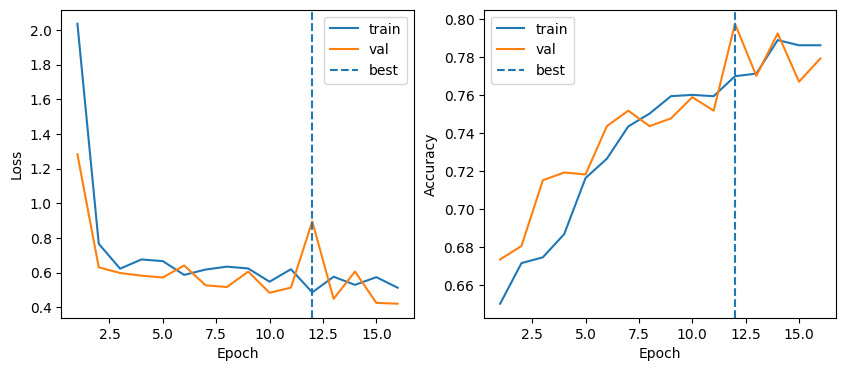

In [10]:
with open(f"mega_hatemoji_custom_loss.obj", "rb") as f:
    train_acc, val_acc, train_losses, val_losses, best_epoch, best_model = pickle.load(f)

fig, ax = plt.subplots(1,2, figsize=(10,4))
epoch_axis = range(1, len(train_losses)+1)
ax[0].plot(epoch_axis, train_losses, label='train')
ax[0].plot(epoch_axis, val_losses, label='val')
ax[0].axvline(best_epoch+1, label='best', linestyle='--')
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
#ax[0].set_xticks(epoch_axis)
ax[0].legend()

ax[1].plot(epoch_axis, train_acc, label='train')
ax[1].plot(epoch_axis, val_acc, label='val')
ax[1].axvline(best_epoch+1, label='best', linestyle='--')
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
#ax[1].set_xticks(epoch_axis)
ax[1].legend()
plt.show()

  0%|          | 0/16 [00:00<?, ?it/s]

[[0.38216561 0.61783439]
 [0.00747384 0.99252616]]


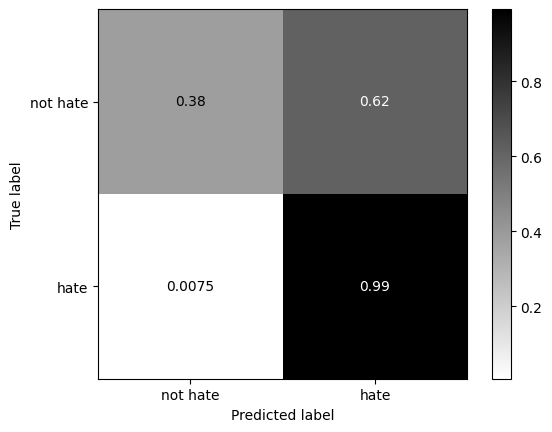

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay

def eval_confusion(model, test_dataloader):
    progress_bar = tqdm(range(len(test_dataloader)))
    model.eval()
    confusion_metric = evaluate.load("confusion_matrix")

    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        
        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

        confusion_metric.add_batch(predictions=predictions, references=batch["labels"])

        progress_bar.update(1)

    confusion_matrix = confusion_metric.compute()["confusion_matrix"]

    return np.array(confusion_matrix)

model.load_state_dict(best_model)
confusion_matrix = eval_confusion(model, test_dataloader)
confusion_matrix_normalized = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_normalized, display_labels=('not hate','hate'))
disp.plot(cmap=plt.cm.binary)

plt.savefig(f"hatemoji_confusion_customloss.png", dpi=300, bbox_inches='tight')

print(confusion_matrix_normalized)